## Importing packages, loading data

In [1]:
# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import multiprocessing as mp
import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

In [2]:
# standard library
import gc
import pickle
gc.enable()

In [302]:
# third-party modules
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
# custom modules
%aimport util
%aimport qtls

In [5]:
expression_df, genotypes_df, qtls_df = {}, {}, {}

expression_df["eQTLs_2018"] = pd.read_table("./data/raw/eQTLs/2018/expression.csv")
genotypes_df["eQTLs_2018"] = pd.read_table("./data/raw/eQTLs/2018/genotypes_filtered.csv")

qtls_df["eQTLs_2018"] = pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv")
qtls_df["eQTLs_2018"].rename({"LOD" : "score"}, axis=1, inplace=True)
qtls_df["eQTLs_2018"]["score"] = MinMaxScaler().fit_transform(
    qtls_df["eQTLs_2018"]["score"].values[:,None]
)
qtls_df["eQTLs_2018"]["score"] = 1 - qtls_df["eQTLs_2018"]["score"]

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", 
    "colocalization", 
    "direct interaction",
    "physical association"
]

In [325]:
interaction_categories = physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)

# genetic_interactions_df = interactome_df[interactome_df.index.isin(
#     genetic_interaction_categories)]
physical_interactions_df = interactome_df[interactome_df.index.isin(
    physical_interaction_categories)]


def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

type2interactome = {}
for edge_type in ["all", "physical", "genetic"]:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(edge_type), "rb") as infile:
        type2interactome[edge_type] = pickle.load(infile)

## Implementation

**Introduction — interacting vs. random:**  
*“Physically interacting genes share more linkages than expected at random”*  

- For each edge, compute the Jaccard coefficient of the sets of markers linked to its endpoints. 
- Then generate the same number of random gene pairs, compute the coefficients. 
- Repeat a few thousand times and average the results. 

Compare distributions of Jaccard coefficients through such statistics, as:

- p-value from MWU test (computationally unfeasible?) 
- mean value
- confidence intervals

A class generating this figure must reside in `qtls` module and be well-documented. 
Let's call it `RandomPairsTest`.

In [229]:
# Было бы очень неплохо добавить автоматические дампы.
# Скажем, с каким-то шагом тупо пиклить целиком класс.
# Это реализовано из коробки в каком-нибудь пакете?

class RandomPairsTest:
    """
    Given a list of QTLs as (marker, gene) pairs and a graph of interactions,
    traverses all of its edges and calculates on the way the Jaccard similarity between
    sets of markers linked to edge's endpoints. When done, generates |E| random edges,
    repeats the same computation. Two distributions — from actual and random edges — 
    are then compared by test statistics (mean value, confidence intervals etc).
    -----------------------------------------------------------------------------------
    This class was designed with map-reduce paradigm in mind. 
    """
    def __init__(self, interactome, qtls_df, score_thresholds, max_iter, n_jobs=-1):
        # TODO: docstring
        assert "SNP" in qtls_df.columns, "provided QTLs don't have marker column"
        assert "gene" in qtls_df.columns, "provided QTLs don't have gene column"
        assert "score" in qtls_df.columns, "provided QTLs don't have associated scores"
        assert np.all((0 <= qtls_df["score"]) & (qtls_df["score"] <= 1)),\
                "scores must be scaled to fit into (0, 1) range"
        assert np.all((0 <= score_thresholds) & (score_thresholds <= 1)),\
                "some thresholds are outside (0, 1) range"
        
        self.interactome = interactome
        self.qtls_df = qtls_df
        self.score_thresholds = score_thresholds
        self.max_iter = max_iter
        
        self.n_edges = self.interactome.ecount()
        self.n_nodes = self.interactome.vcount()
        self.node_names = self.interactome.vs["name"]

        self.edges = [
            (self.node_names[e.source], self.node_names[e.target])
            for e in self.interactome.es
        ]
        
        self.n_jobs = n_jobs if n_jobs > 0 else mp.cpu_count()
        self.simulation_results = defaultdict(list)
    
    @staticmethod
    def jaccard_from_edge(edge, gene2linked_markers):
        """
        -----------------------------------------
        @param edge — (str, str) — tuple of nodes
        @param gene2linked_markers — dict 
            maps gene name into the list of 
            markers linked to that gene
        -----------------------------------------
        @note   returns -1 if both endpoints have 
                no markers linked to them
        """
        source, target = edge
        if (not gene2linked_markers[source].size 
            and not gene2linked_markers[target].size): return -1 
        
        return qtls.jaccard(set(gene2linked_markers[source]), 
                            set(gene2linked_markers[target]))
    
    @staticmethod
    def linkage_similarity(thresh, edges_list, node_names, qtls_df, gene2linked_markers):        
        jaccard = np.fromiter((RandomPairsTest.jaccard_from_edge(edge, gene2linked_markers)
                               for edge in edges_list), dtype=np.float32)
        return jaccard[jaccard >= 0]
    
    
    @staticmethod
    def process_threshold(thresh, edges_list, node_names, qtls_df, max_iter):
        """
        QTL filtering and Jaccard coefficient computation.
        ----------------------------------------------------------
        @param thresh — float — score cutoff
        @param edges_list — list(str)
            list of edges given as pairs of gene names
        @param node_names — list(str)
            list of gene names corresponding to the 
            nodes of the interactome graph
        @param qtls_df — pd.DataFrame
            must contain such columns as ["SNP", "gene", "score"]
        @param score_thresholds — list(float)
            list of score cutoffs used for QTL filtering:
            on each iteration some QTLs are labeled as
            insiginificant (based of score) and are filtered out
        @param max_iter — int — number of randomization iterations
        ----------------------------------------------------------
        @returns    a dictionary with mean jaccard similarity both 
                    for real interactome and for each simulation,
                    and also a vector of p-values obtained through
                    MWU test that compared the actual Jaccard 
                    coefficient distribution with those arising
                    during simulation runs.
        ----------------------------------------------------------
        @note   staticmethod decorator makes this method 
                compatible with joblib (or multiprocessing module)
        """
        
        signif_qtls_df = qtls_df[qtls_df["score"] <= thresh]
        gene2linked_markers = {v : qtls.linked_markers(signif_qtls_df, v)
                               for v in node_names}
        
        # It's possible to manually remove the nodes without linkages
        # by taking a subgraph of the interactome graph.  
        # This may lead to considerable increase in performance.
        
        n_nodes = len(node_names)
        n_edges = len(edges_list)
        
        random_edges = [
            [(node_names[u], node_names[v]) 
            for u, v in util.sample_combinations(
                (n_nodes, n_nodes), 
                n_edges
            )]
            for _ in range(max_iter)
        ]
            
        linksim = {
            "actual" : RandomPairsTest.linkage_similarity(
                thresh, 
                edges_list, 
                node_names, 
                signif_qtls_df,
                gene2linked_markers
            ),
            "random" : [
                RandomPairsTest.linkage_similarity(
                    thresh,
                    random_edges[i], 
                    node_names, 
                    signif_qtls_df,
                    gene2linked_markers
                    
                ) for i in range(max_iter)
            ]
        }
        

        simulation_results = {
            "actual-mean-linksim" : np.mean(linksim["actual"]),
            "random-mean-linksim" : [np.mean(randiter) for randiter in linksim["random"]],
            "p-value" : [np.median([
                sps.mannwhitneyu(linksim["actual"], 
                                 linksim["random"][i], 
                                 alternative="two-sided")[1]
                for i in range(max_iter)
            ])],
            "actual-edge-has-linkages" : len(linksim["actual"]),
            "random-edge-has-linkages" : [len(linksim["random"][i]) 
                                          for i in range(max_iter)]
        }
        del gene2linked_markers, linksim, signif_qtls_df        
        return simulation_results

    def map(self):
        """
        Computes the averaged Jaccard similarity for real interactome.
        Then simulates self.max_iter random lists of edges and 
        repeats the computations with those. 
        
        Method's name comes form the fact that it distributes the
        simulation iterations among workers on cluster.
        --------------------------------------------------------------
        @returns None (results are stored at self.simulation_results)
        """
        mapped = \
            Parallel(n_jobs=self.n_jobs)(
                delayed(RandomPairsTest.process_threshold)(
                    thresh, self.edges, self.node_names, 
                    self.qtls_df, self.max_iter
                )
                for thresh in self.score_thresholds
            )
        
        for test_stat in ["actual-mean-linksim", "p-value", "actual-edge-has-linkages"]:
            self.simulation_results[test_stat] = np.concatenate([np.atleast_1d(run[test_stat]) 
                                                                 for run in mapped])
            
        for test_stat in ["random-mean-linksim", "random-edge-has-linkages"]:    
            self.simulation_results[test_stat] = np.vstack([run[test_stat] 
                                                            for run in mapped])
        
    def reduce(self, summarize=True):
        """
        Summarizes the self.simulation_results when asked to do so
        """
        if summarize:
            mapped = self.simulation_results # for brevity
            simulation_summary = {
                "linksim" : {
                    "{}%".format(q) : 
                    np.quantile(mapped["random-mean-linksim"], q, axis=1)
                    for q in [0.25, 0.5, 0.75]
                },
                "edge-has-linkages" :"linksim" : {
                    "{}%".format(q) : 
                    np.quantile(mapped["random-edge-has-linkages"], q, axis=1)
                    for q in [0.25, 0.5, 0.75]
                }
            }
            actual_summary = {
                "linksim" : { "mean" : mapped["actual-mean-linksim"] },
                "edge-has-linkages" : { "mean" : mapped["actual-edge-has-linkages"] }
            }
            return {"actual" : actual_summary, 
                    "p-value" : mapped["p-value"],
                    "random" : simulation_summary}
        return self.simulation_results
    
    def map_reduce(self, summarize=True):
        """
        Master-function that initiates the pipeline.
        """
        self.map()
        return self.reduce(summarize)

## Running the test suite. 

Works like a charm.

In [17]:
print("Total number of eQTLs: {}".format(qtls_df["eQTLs_2018"].shape[0]))
qtls_df["eQTLs_2018"].describe()

Total number of eQTLs: 36498


,r,score,markerPlotCoordinate,genePlotCoordinate,gene.to.CI.dist,var.exp,lm.coeff
count,36498.000000,36498.000000,3.649800e+04,3.649800e+04,3.649800e+04,36498.000000,5094.000000
mean,0.007048,0.981469,6.921678e+06,6.079779e+06,1.547626e+04,0.023178,-0.027348
std,0.225073,0.051640,3.162605e+06,3.476267e+06,8.512478e+04,0.177472,0.300425
min,-0.960872,0.000000,3.304000e+04,3.156700e+04,0.000000e+00,-0.943896,-0.960329
25%,-0.151659,0.986066,3.920026e+06,3.064589e+06,0.000000e+00,-0.122869,-0.196272
50%,-0.109597,0.994802,7.905399e+06,6.066781e+06,0.000000e+00,0.036012,-0.107311
75%,0.159328,0.997601,9.623949e+06,9.102150e+06,0.000000e+00,0.133914,0.172624
max,0.949410,1.000000,1.205137e+07,1.212023e+07,1.283760e+06,0.937534,0.944469


In [8]:
score_thresholds = np.linspace(0.8, 1, 10)

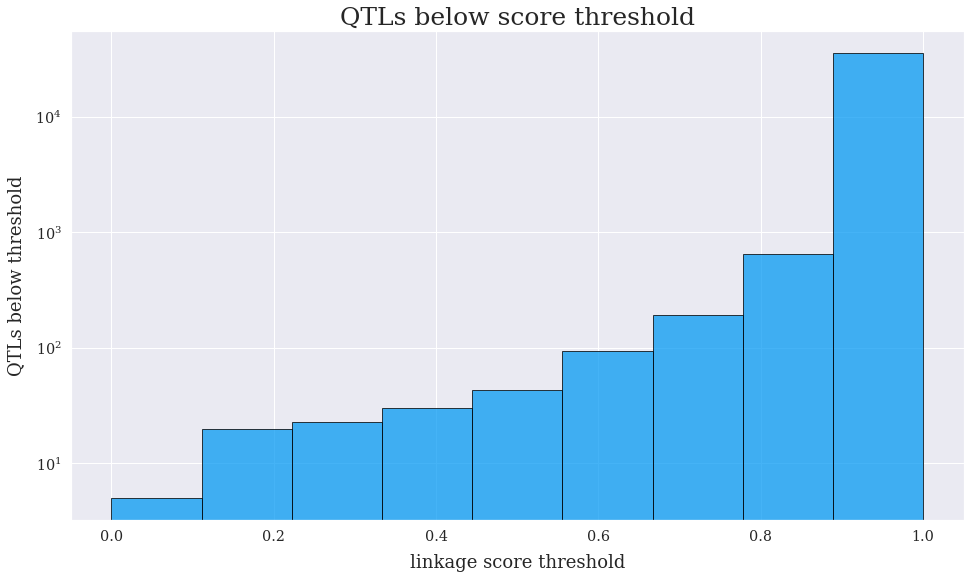

In [366]:
sns.set(style="darkgrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})
fig = plt.figure(figsize=(16,9));
plt.title("QTLs below score threshold", fontsize=25);
plt.xlabel("linkage score threshold", fontsize=18, labelpad=10);
plt.ylabel("QTLs below threshold", fontsize=18, labelpad=10);
plt.yscale("log")
plt.hist(qtls_df["eQTLs_2018"].score, 
         bins=np.linspace(0,1,10), 
         alpha=0.75,
         color="xkcd:azure", 
         edgecolor="black");

In [367]:
# type2simulation_results = {}
for edge_type in ["all"]:
    rptest = RandomPairsTest(type2interactome[edge_type], 
                             qtls_df["eQTLs_2018"],
                             score_thresholds,
                             max_iter=128, 
                             n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

In [368]:
# computation takes circa 20 minuts, so let's pickle and dump the results
with open("data/tmp/figure-1/type2simulation_results.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

## Visualizing results

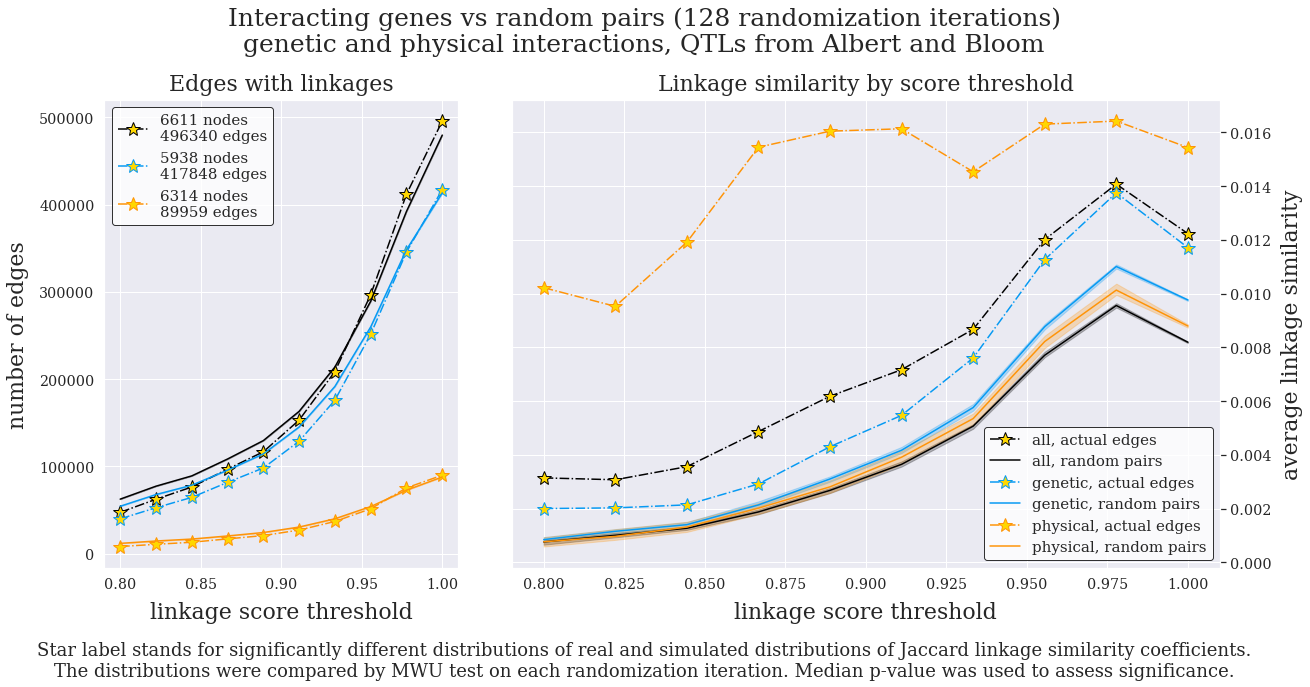

In [390]:
sns.set(style="darkgrid", font_scale=1.3)
sns.set_style({'font.family':'serif'})
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
fig.suptitle("Interacting genes vs random pairs (128 randomization iterations)\n"
             "genetic and physical interactions, QTLs from Albert and Bloom", 
             fontsize=25)
fig.align_labels(axs=ax)

ax[1].set_title("Linkage similarity by score threshold", fontsize=22, pad=10)
ax[1].set_xlabel("linkage score threshold", fontsize=22, labelpad=10)
ax[1].set_ylabel("average linkage similarity", fontsize=22, labelpad=10)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
# ax[0].yaxis.grid(False)

ax[0].set_title("Edges with linkages", fontsize=22, pad=10)
ax[0].set_xlabel("linkage score threshold", fontsize=22, labelpad=10)
ax[0].set_ylabel("number of edges", fontsize=22, labelpad=10)
ax[0].yaxis.set_label_position("left")

# ax[1].set_yscale("log")
# ax[1].yaxis.grid(False)
# ax[1].set_yticks(10 ** np.array([4, 4.5, 5, 5.5, 6]))
# ax[1].set_yticklabels(r"$10^{{{}}}$".format(i) for i in np.array([4, 4.5, 5, 5.5, 6]))

significant_point_ids = list(np.where(np.ravel(simulation_results["p-value"]) <= 0.05))
caption=("Star label stands for significantly different distributions of real and simulated "
         "distributions of Jaccard linkage similarity coefficients.\n"
         "The distributions were compared by MWU test on each randomization iteration. "
         "Median p-value was used to assess significance.")
fig.text(0.5, 0.05, caption, wrap=True, horizontalalignment='center', fontsize=18)

colors = {"all" : "black",
          "genetic" : "xkcd:azure", 
          "physical" : "xkcd:tangerine"}

for edge_type in ["all", "genetic", "physical"]:
    simulation_results = type2simulation_results[edge_type]
    ax[1].plot(score_thresholds, 
             simulation_results["actual"]["linksim"]["mean"], 
             label="{}, actual edges".format(edge_type), 
             color=colors[edge_type],
             linestyle="-.",
             marker="*",
             markevery=significant_point_ids,
             markerfacecolor="gold",
             markersize=15)
    ax[1].plot(score_thresholds, 
             simulation_results["random"]["linksim"]["50%"], 
             label="{}, random pairs".format(edge_type), 
             c=colors[edge_type])
    ax[1].fill_between(score_thresholds, 
                     simulation_results["random"]["linksim"]["25%"],  
                     simulation_results["random"]["linksim"]["75%"], 
                     color=colors[edge_type], alpha=0.25)

    legend = ax[1].legend(loc="lower right", fontsize=15);
    frame = legend.get_frame();
    frame.set_facecolor("white");
    frame.set_edgecolor("black");

    ax[0].plot(score_thresholds, 
               simulation_results["actual"]["edge-has-linkages"]["mean"], 
               label="{} nodes\n{} edges".format(
                   type2interactome[edge_type].vcount(),
                   type2interactome[edge_type].ecount()
               ),
               color=colors[edge_type], 
               marker="*",
               linestyle="-.",
               markevery=significant_point_ids,
               markerfacecolor="gold",
               markersize=15)
    ax[0].plot(score_thresholds, 
               simulation_results["random"]["edge-has-linkages"]["50%"], 
#                label="{}, random pairs".format(edge_type),
               color=colors[edge_type])
    ax[0].fill_between(score_thresholds, 
                 simulation_results["random"]["edge-has-linkages"]["25%"],  
                 simulation_results["random"]["edge-has-linkages"]["75%"], 
                 color=colors[edge_type], alpha=0.25)
    
    legend = ax[0].legend(loc="upper left", fontsize=15);
    frame = legend.get_frame();
    frame.set_facecolor("white");
    frame.set_edgecolor("black");
